In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


In [2]:
dt = 0.1
tend = 20*np.pi
ts = np.arange(0,tend,step=dt)

x_r =  1.5*np.sin(0.1*ts)
y_r =  1.5*np.sin(0.2*ts)


xdot_r = 0.15*np.cos(0.1*ts)
ydot_r = 0.30*np.cos(0.2*ts)

xddot_r = -0.015*np.sin(0.1*ts)
yddot_r = -0.060*np.sin(0.2*ts)

theta = np.zeros_like(xdot_r)
omega = np.zeros_like(xddot_r)
vs = np.zeros_like(x_r)
for i in range(len(theta)):
    theta[i] = np.arctan2(ydot_r[i],xdot_r[i])
    omega[i] = 1.0/(1.0 + (ydot_r[i]/xdot_r[i])**2)*(-0.4*np.cos(0.1*ts[i])*np.sin(0.2*ts[i]) + 0.2*np.sin(0.1*ts[i])*np.cos(0.2*ts[i]))/np.cos(0.1*ts[i])**2
    vs[i] = np.sqrt(xdot_r[i]**2 + ydot_r[i]**2)

#plt.plot(x_r,y_r)

u = jnp.vstack((vs, omega)).T
print(u.shape)



(629, 2)


In [3]:
from typing import Callable, Union
import jax.numpy as jnp
import equinox
import jax
import functools

v_r = vs[0]
w_r = omega[0]


def runge_kutta_integrator(dynamics, dt=0.1):
    # zero-order hold
    def integrator(x, u, t):
        dt2 = dt / 2.0
        k1 = dynamics(x, u, t)
        k2 = dynamics(x + dt2 * k1, u, t + dt2)
        k3 = dynamics(x + dt2 * k2, u, t + dt2)
        k4 = dynamics(x + dt * k3, u, t + dt)
        return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return integrator

@functools.partial(jax.jit, static_argnames=["dynamics"])
def linearize(dynamics, state, control, t):
    A, B = jax.jacobian(dynamics, [0, 1])(state, control, t)
    C = dynamics(state, control, t) - A @ state - B @ control
    return A, B, C

class Dynamics(equinox.Module):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def linearize(self, state0, control0, time):
        A, B, C = linearize(self.dynamics_func, state0, control0, time)
        return A @ state0 + B @ control0 + C

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

class ControlAffineDynamics(Dynamics):
    drift_dynamics: Callable
    control_jacobian: Callable
    state_dim: int
    control_dim: int

    def __init__(self, drift_dynamics, control_jacobian, state_dim, control_dim):
        self.drift_dynamics = drift_dynamics
        self.control_jacobian = control_jacobian
        def dynamics_func(x, u, t):
            
            return drift_dynamics(x,t) + control_jacobian(x,t) @ u
        super().__init__(dynamics_func, state_dim, control_dim)

    def open_loop_dynamics(self, state, time=0.):
        return self.drift_dynamics(state, time)
    
class Unicycle(ControlAffineDynamics):
    state_dim: int = 3
    control_dim: int = 2

    def __init__(self):
        def drift_dynamics(state, time):
            return jnp.array([0., 0., 0.])
        def control_jacobian(state, time):
            _, _, th = state
            # v, om = control
            return jnp.array(
                [
                    [jnp.cos(th), 0.],
                    [jnp.sin(th), 0.],
                    [0., 1.]
                ]
            )

        super().__init__(drift_dynamics, control_jacobian, self.state_dim, self.control_dim)

class UnicycleError(ControlAffineDynamics):
    state_dim: int = 3
    control_dim: int = 2
    v_r: float
    w_r: float

    def __init__(self, v_r, w_r):
        self.v_r = v_r
        self.w_r = w_r

        def drift_dynamics(state, time):
            x,y,th = state
            
            return jnp.array([self.v_r*jnp.cos(th), self.v_r*jnp.sin(th), self.w_r])
        
        def control_jacobian(state, time):
            x, y, th = state
            # v, om = control
            return jnp.array([[-1.0, y],
                              [0.0, -x],
                              [0., -1.]])

        super().__init__(drift_dynamics, control_jacobian, self.state_dim, self.control_dim)

    def set_vr(self, vr):
        self.v_r = vr
    
    def set_wr(self, wr):
        self.w_r = wr


def get_discrete_time_dynamics(continuous_time_dynamics: Dynamics, dt: float) -> Dynamics:
    discete_dynamics = runge_kutta_integrator(continuous_time_dynamics, dt)
    return Dynamics(discete_dynamics, continuous_time_dynamics.state_dim, continuous_time_dynamics.control_dim)

# def get_linearized_dynamics(dynamics: Dynamics, state0, control0, time):
#     A, B, C = linearize(dynamics, state0, control0, time)
#     return LTIDynamics(A, B, C)
        

In [4]:

# ct_robot_dynamics = UnicycleError() # robot dynamics
# dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics

ct_robot_dynamics_abs = Unicycle()
dt_robot_dynamics_abs = get_discrete_time_dynamics(ct_robot_dynamics_abs, dt=dt)

# state_dim = dt_robot_dynamics.state_dim
# control_dim = dt_robot_dynamics.control_dim

@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t1 = t0
    for c in controls:
        state = dt_dynamics(state, c, t1)
        states.append(state)
        t1 += dt
    return jnp.stack(states)

# IC = jnp.array([0.0, 0.0, 0.0])
# IC_abs = jnp.array([0.0, 0.0, theta[0]])
# trajectory = simulate_discrete_time_dynamics(dt_robot_dynamics, IC, u, 0.0, dt)
# trajectory_abs = simulate_discrete_time_dynamics(dt_robot_dynamics_abs, IC_abs, u, 0.0, dt)




In [5]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

import cvxpy as cp

from map import update_plot
from env_setup import environment_gen

%load_ext ipympl
%matplotlib widget

The ipympl module is not an IPython extension.


In [6]:
#from convexify_obstacles import to_convex_hull
#from shapely.geometry import Point, Polygon

num_obstacles=15

obstacles = environment_gen(num_obstacles=num_obstacles,obst_scale=0.2,obst_var=0.05,map_size=4,step_size=1,seed=71)

"""convex_obst = to_convex_hull(obstacles)

num_convex_obst = len(convex_obst)"""

num_time_steps = ts.shape[0]


Seed Set


In [7]:
import numpy as np

def merge_overlapping_obstacles(obstacles: np.ndarray) -> np.ndarray:
    """
    obstacles: (N, 3) array with columns [x, y, r].
    Returns: (M, 3) array of merged circles.
    Any connected group of overlapping circles is replaced by one
    bounding circle (center = mean of centers, radius big enough to
    cover all original circles).
    """
    N = obstacles.shape[0]
    used = np.zeros(N, dtype=bool)
    merged = []

    for i in range(N):
        if used[i]:
            continue

        # start new group with obstacle i
        group_idxs = [i]
        used[i] = True

        # simple BFS over overlap graph
        changed = True
        while changed:
            changed = False
            for j in range(N):
                if used[j]:
                    continue
                # check if j overlaps with any circle in current group
                for k in group_idxs:
                    xk, yk, rk = obstacles[k]
                    xj, yj, rj = obstacles[j]
                    d = np.hypot(xj - xk, yj - yk)
                    if d <= rk + rj:   # overlapping or touching
                        group_idxs.append(j)
                        used[j] = True
                        changed = True
                        break

        # now we have one connected group "group_idxs"
        xs = obstacles[group_idxs, 0]
        ys = obstacles[group_idxs, 1]
        rs = obstacles[group_idxs, 2]

        # choose center as mean of centers
        cx = xs.mean()
        cy = ys.mean()

        # radius must cover all original circles
        max_r = 0.0
        for (xo, yo, ro) in obstacles[group_idxs]:
            d = np.hypot(xo - cx, yo - cy)
            max_r = max(max_r, d + ro)

        merged.append([cx, cy, max_r])

    return np.array(merged)


# obstacles: (N,3) [x, y, r]
combined_obstacles = merge_overlapping_obstacles(obstacles)
num_combined = combined_obstacles.shape[0]


In [8]:
@jax.jit
def h(state, obstacle, radius):
    x, y, th = state
    x_o, y_o = obstacle
    result = (x-x_o)**2 + (y-y_o)**2 - radius**2
    return result


In [9]:
"""a = 0.01
lda = 1000

alpha = 5

c1 = 0.2
c2 = 2
c3 = 2"""

alpha = 2.5

lda = 6

c1 = 0.3 # weaker lateral error push
c2 = 1 # softer curvature/heading term
c3 = 2 # moderate heading correction
print(lda)
print(alpha)
print(c1)
print(c2)
print(c3)

ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics

dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics


v = u[0]
w = u[1]

Xs = [jnp.array([0, 0, 0])]
Xs_abs = [(jnp.array([x_r[0], y_r[0], theta[0]])-Xs[0])]

controls = []
gamma = cp.Variable()



# absolute state, not error
X_world = Xs_abs[-1]     # e.g. from a separate absolute dynamics, or X_world = X + ref, etc.
x_w, y_w, th_w = X_world



for i in range(0,len(ts)):
    X = Xs[-1]
    x, y, th = X

    t = ts[i]
    X_ref = jnp.array([x_r[i], y_r[i], theta[i]])
    X_abs = X_ref - X
    v_r = vs[i]
    w_r = omega[i]
    vr=1.0
    
    ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics
    dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
    
    u_ref = jnp.array([v_r, w_r])
    
    added_control = jnp.array([c1*x/jnp.sqrt(x**2+y**2+1), c2*v_r*(y*jnp.cos(th/2)-x*jnp.sin(th/2)/jnp.sqrt(1+x**2+y**2))+c3*jnp.sin(th/2)])
    control = u_ref+added_control

    u = cp.Variable(2)
    v = u[0]
    w = u[1]



    """-------------------------
    ------ FOR EACH OBST -------
    -------------------------"""
    '''constraints = [v >= 0]
    constraints.append(gamma >= 0)
    for obst in range(num_convex_obst):
        
        X_world = X_abs     # e.g. from a separate absolute dynamics, or X_world = X + ref, etc.
        x, y, th = X_world

        poly_obst = Polygon(convex_obst[obst])
        pt = Point(x, y)


        dist = poly_obst.boundary.distance(pt)
        inside = poly_obst.contains(pt) or poly_obst.touches(pt)
        h_curr = -dist if inside else dist


        boundary = poly_obst.boundary
        closest_pt = boundary.interpolate(boundary.project(pt))
        x_b, y_b = closest_pt.x, closest_pt.y


        dx = x - x_b
        dy = y - y_b
        n_norm = np.hypot(dx, dy) + 1e-9
        n_x = dx / n_norm
        n_y = dy / n_norm

        if inside:
            n_x = -n_x
            n_y = -n_y

        h_dot_curr = (n_x * jnp.cos(th) + n_y * jnp.sin(th)) * v

        constraints.append(h_dot_curr >= -alpha * h_curr - gamma)'''
    
    # how many closest obstacles to keep
    n_closest = 1  # set this to whatever N you want

    h_currs = []
    h_dots  = []
    h_ddots = []

    constraints = []
    # first pass: compute h, h_dot, h_ddot for all obstacles
    for obst in range(num_combined):

        obstacle_location = combined_obstacles[obst, :2]
        obstacle_radius   = combined_obstacles[obst, 2]

        # original Lyapunov state in whatever frame you used before
        h_curr = h(X_abs, obstacle_location, obstacle_radius)

        h_dot_curr = (
            (X_abs[0] - obstacle_location[0]) * v * jnp.cos(X_abs[2]) +
            (X_abs[1] - obstacle_location[1]) * v * jnp.sin(X_abs[2])
        )

        h_ddot_curr = (
            v**2
            - (X_abs[0] - obstacle_location[0]) * w * jnp.sin(X_abs[2])
            + (X_abs[1] - obstacle_location[1]) * w * jnp.cos(X_abs[2])
        )

        h_currs.append(h_curr)
        h_dots.append(h_dot_curr)
        h_ddots.append(h_ddot_curr)

    h_array = np.array(h_currs)
    closest_indices = np.argsort(h_array)[:n_closest]

    for idx in closest_indices:
        constraints.append(h_dots[idx] >= -alpha * h_currs[idx])

    obj1 = (1/2 * cp.norm((u - control))**2) + lda * gamma**2

    obj = cp.Minimize(obj1)
    prob = cp.Problem(obj, constraints)
    prob.solve()

    if u.value is None:
        print(f"[WARN] infeasible at i={i}, t={ts[i]}, status={prob.status}")
        print("X_abs:", X_abs)
        for obst in range(num_obstacles):
            obstacle_location = obstacles[obst,:2]
            obstacle_radius = obstacles[obst,2]
            h_curr = h(X_abs, obstacle_location, obstacle_radius)
            print(f"  obst {obst}: loc={obstacle_location}, R={obstacle_radius}, h={h_curr}")
        break


    control = u.value
    controls.append(control)


    New_X_rel = simulate_discrete_time_dynamics(dt_robot_dynamics, X, [control], t, dt)
    New_X_abs = simulate_discrete_time_dynamics(dt_robot_dynamics_abs, X_abs, [control], t, dt)

    Xs_abs.append(New_X_abs[-1])
    Xs.append(New_X_rel[-1])


6
2.5
0.3
1
2


In [10]:
Xs = np.array(Xs)

#Robot
#xt = -Xs[:-1,0] + x_r
#yt = -Xs[:-1,1] + y_r#[:4]
#tht = -Xs[:-1,2] + theta#[:4]

Xs_abs = np.array(Xs_abs)
x_abs = Xs_abs[:-1, 0]
y_abs = Xs_abs[:-1, 1]


error = jnp.sqrt(Xs[:-1,0]**2 + Xs[:-1,1]**2)


robot_traj_A = np.vstack((-Xs[:-1,0] + x_r,-Xs[:-1,1] + y_r)).T
robot_traj_B = np.vstack((x_abs,y_abs)).T


v_act = np.array(controls)[:,0]
w_act = np.array(controls)[:,1]

robot_controls = np.vstack((v_act,w_act)).T

reference_traj = np.vstack((x_r,y_r,theta)).T
reference_controls = np.vstack((vs,omega)).T


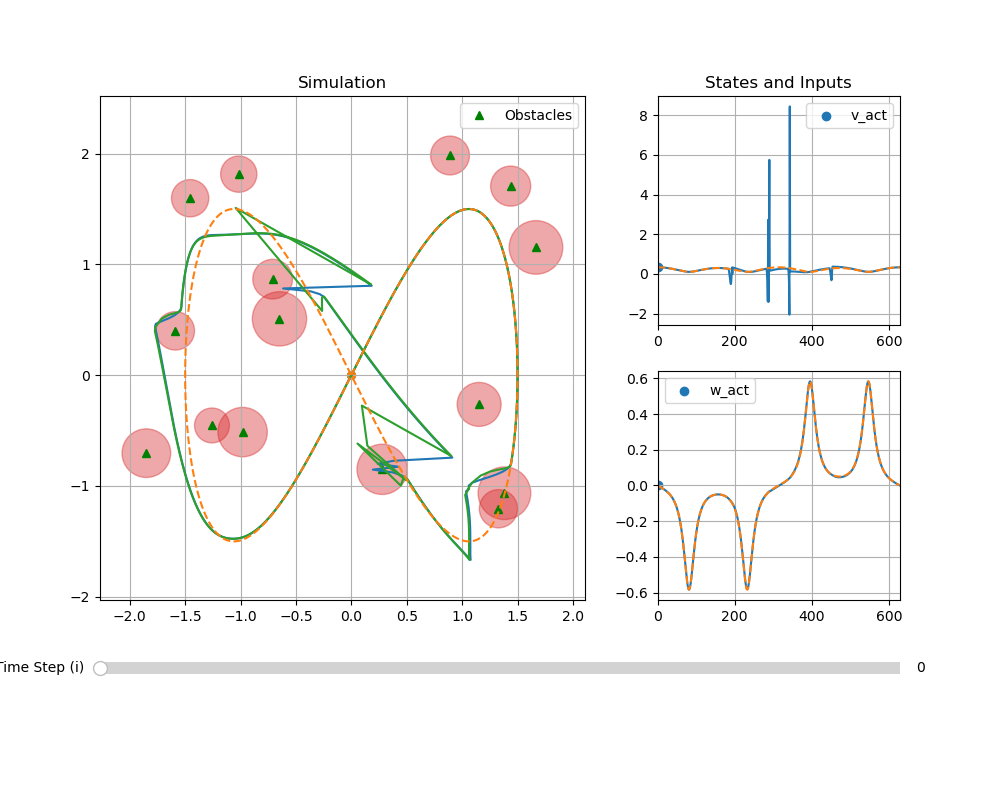

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

i_init = 0

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(
    2, 2,
    width_ratios=[2, 1],   # left wide, right narrow
    height_ratios=[1, 1]   # two rows on the right
)

ax_left   = fig.add_subplot(gs[:, 0])   # spans both rows on the left
ax_right1 = fig.add_subplot(gs[0, 1])   # top-right
ax_right2 = fig.add_subplot(gs[1, 1])   # bottom-right

axs = [ax_left, ax_right1, ax_right2]   # so you can index axs[0], axs[1], axs[2]

plt.subplots_adjust(left=0.1, bottom=0.25)  # space for slider

# --- slider ---
ax_i = plt.axes([0.1, 0.15, 0.8, 0.03])

slider_i = Slider(
    ax_i, 
    'Time Step (i)',
    0,
    num_time_steps - 1,
    valinit=i_init,
    valstep=1
)

def slider_callback(val):
    i_val = int(slider_i.val)
    update_plot(
        i_val,
        robot_trajectory_A=robot_traj_A,
        robot_trajectory_B=robot_traj_B,
        reference_trajectory=reference_traj,
        robot_controls=robot_controls,
        reference_controls=reference_controls,
        obstacles=obstacles,
        fig=fig,
        axs=axs,
        #convex_hulls=convex_obst
    )

slider_i.on_changed(slider_callback)

update_plot(
    i_init,
    robot_trajectory_A=robot_traj_A,
    robot_trajectory_B=robot_traj_B,
    reference_trajectory=reference_traj,
    robot_controls=robot_controls,
    reference_controls=reference_controls,
    obstacles=obstacles,
    fig=fig,
    axs=axs,
    #convex_hulls=convex_obst
)

plt.show()
